In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [42]:
ticker ="IBM"

data = yf.download(ticker, start="2010-01-01", end="2023-10-01")

[*********************100%***********************]  1 of 1 completed


In [43]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2010-01-04,74.764580,75.058106,73.861424,74.047698,6438444
2010-01-05,73.861435,74.425910,73.438079,74.329946,7156104
2010-01-06,73.381592,74.222659,73.274344,73.765432,5863144
2010-01-07,73.127602,73.522731,72.766338,73.308231,6109268
2010-01-08,73.861435,73.900946,72.845382,72.856671,4390271


In [44]:
del data["High"]
del data["Low"]
del data["Open"]

In [45]:
data

Price,Close,Volume
Ticker,IBM,IBM
Date,,
2010-01-04,74.764580,6438444
2010-01-05,73.861435,7156104
2010-01-06,73.381592,5863144
2010-01-07,73.127602,6109268
2010-01-08,73.861435,4390271
...,...,...
2023-09-25,139.784180,2694200
2023-09-26,136.692307,4824700


In [46]:
data.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', name='Date', length=3459, freq=None)

<Axes: xlabel='Date'>

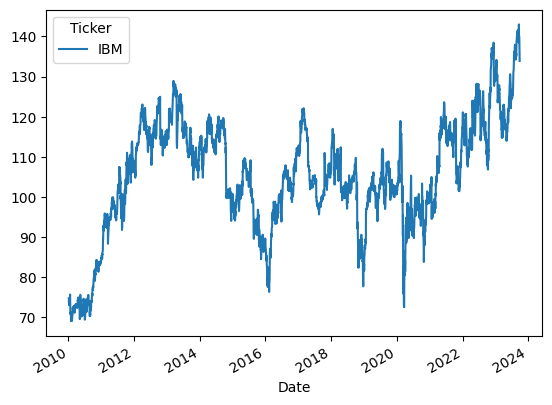

In [47]:
data.plot.line(y="Close", use_index=True)

In [48]:
data

Price,Close,Volume
Ticker,IBM,IBM
Date,,
2010-01-04,74.764580,6438444
2010-01-05,73.861435,7156104
2010-01-06,73.381592,5863144
2010-01-07,73.127602,6109268
2010-01-08,73.861435,4390271
...,...,...
2023-09-25,139.784180,2694200
2023-09-26,136.692307,4824700


In [49]:
# prompt: check the column names

data.columns


MultiIndex([( 'Close', 'IBM'),
            ('Volume', 'IBM')],
           names=['Price', 'Ticker'])

In [50]:
# Removing multi level Index as it could hinder the accuracy of our model
data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in data.columns]


In [51]:
data

,Close_IBM,Volume_IBM
Date,,
2010-01-04,74.764580,6438444
2010-01-05,73.861435,7156104
2010-01-06,73.381592,5863144
2010-01-07,73.127602,6109268
2010-01-08,73.861435,4390271
...,...,...
2023-09-25,139.784180,2694200
2023-09-26,136.692307,4824700
2023-09-27,136.625488,4439800


In [52]:
data.columns

Index(['Close_IBM', 'Volume_IBM'], dtype='object')

In [53]:
data = data.rename(columns={"Close_IBM":"Close", "Volume_IBM":"Volume"})

In [54]:
data = data[['Close', 'Volume']].copy()

In [55]:
data["Prediction"] = data["Close"].shift(-30)

In [56]:
data

,Close,Volume,Prediction
Date,,,
2010-01-04,74.764580,6438444,71.628929
2010-01-05,73.861435,7156104,72.468071
2010-01-06,73.381592,5863144,72.116554
2010-01-07,73.127602,6109268,71.923790
2010-01-08,73.861435,4390271,71.702644
...,...,...,...
2023-09-25,139.784180,2694200,NaN
2023-09-26,136.692307,4824700,NaN
2023-09-27,136.625488,4439800,NaN


In [57]:
# Droping Nan

data = data.dropna()

In [58]:
data

,Close,Volume,Prediction
Date,,,
2010-01-04,74.764580,6438444,71.628929
2010-01-05,73.861435,7156104,72.468071
2010-01-06,73.381592,5863144,72.116554
2010-01-07,73.127602,6109268,71.923790
2010-01-08,73.861435,4390271,71.702644
...,...,...,...
2023-08-11,136.577774,2526000,139.784180
2023-08-14,135.423096,4226400,136.692307
2023-08-15,135.384918,3656600,136.625488


In [59]:
# Feature Engineering
data['Ma7'] = data['Close'].rolling(window=7).mean()  # 7-day moving average
data['Ma30'] = data['Close'].rolling(window=30).mean()  # 30-day moving average
data['Roc'] = data['Close'].pct_change(periods=30)  # 30-day rate of change
data['Std30'] = data['Close'].rolling(window=30).std()  # 30-day standard deviation
data['Bollinger_Upper'] = data['Ma30'] + (2 * data['Std30'])  # Upper Bollinger Band
data['Bollinger_Lower'] = data['Ma30'] - (2 * data['Std30'])  # Lower Bollinger Band
data['Ema7'] = data['Close'].ewm(span=7, adjust=False).mean()  # 7-day exponential moving average
data['Ema30'] = data['Close'].ewm(span=30, adjust=False).mean()  # 30-day exponential moving average

# Lagged Features
for i in range(1, 31):
    data[f'Close_{i}'] = data['Close'].shift(i)

# Volume Features
data['Volume_MA_7'] = data['Volume'].rolling(window=7).mean()  # 7-day volume moving average
data['Volume_MA_30'] = data['Volume'].rolling(window=30).mean()  # 30-day volume moving average

# Drop rows with NaN values (due to rolling windows and lag features)
data = data.dropna()


<ipython-input-59-6308c9b1f12d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ma7'] = data['Close'].rolling(window=7).mean()  # 7-day moving average
<ipython-input-59-6308c9b1f12d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ma30'] = data['Close'].rolling(window=30).mean()  # 30-day moving average
<ipython-input-59-6308c9b1f12d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [60]:
data

,Close,Volume,Prediction,Ma7,Ma30,Roc,Std30,Bollinger_Upper,Bollinger_Lower,Ema7,...,Close_23,Close_24,Close_25,Close_26,Close_27,Close_28,Close_29,Close_30,Volume_MA_7,Volume_MA_30
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-17,71.628929,6095460,72.717567,70.242215,71.730311,-0.041940,1.887717,75.505744,67.954878,70.615641,...,73.511475,73.669487,73.088081,73.861435,73.127602,73.381592,73.861435,74.764580,6.379629e+06,7.939579e+06
2010-02-18,72.468071,5780091,72.717567,70.722540,71.683866,-0.018865,1.850244,75.384353,67.983378,71.078749,...,74.685555,73.511475,73.669487,73.088081,73.861435,73.127602,73.381592,73.861435,6.350849e+06,7.893712e+06
2010-02-19,72.116554,6593043,73.341293,71.044920,71.641698,-0.017239,1.824453,75.290604,67.992792,71.338200,...,74.386383,74.685555,73.511475,73.669487,73.088081,73.861435,73.127602,73.381592,6.389491e+06,7.918042e+06
2010-02-22,71.923790,3983273,73.103111,71.372163,71.601571,-0.016462,1.803766,75.209103,67.994038,71.484598,...,75.718529,74.386383,74.685555,73.511475,73.669487,73.088081,73.861435,73.127602,6.178647e+06,7.847176e+06
2010-02-23,71.702644,4803127,72.847961,71.593293,71.529611,-0.029228,1.752845,75.035301,68.023921,71.539109,...,73.522713,75.718529,74.386383,74.685555,73.511475,73.669487,73.088081,73.861435,6.104366e+06,7.860938e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11,136.577774,2526000,139.784180,136.740359,131.120509,0.079867,4.764132,140.648774,121.592245,136.412870,...,126.834946,125.382072,124.608467,124.683960,126.646278,126.108521,126.240593,126.476463,3.943286e+06,4.245613e+06
2023-08-14,135.423096,4226400,136.692307,136.618125,131.426593,0.072738,4.734684,140.895961,121.957224,136.165426,...,125.325478,126.834946,125.382072,124.608467,124.683960,126.646278,126.108521,126.240593,3.982500e+06,4.245280e+06
2023-08-15,135.384918,3656600,136.625488,136.518742,131.735806,0.073559,4.677967,141.091740,122.379872,135.970299,...,126.344398,125.325478,126.834946,125.382072,124.608467,124.683960,126.646278,126.108521,3.901571e+06,4.317930e+06


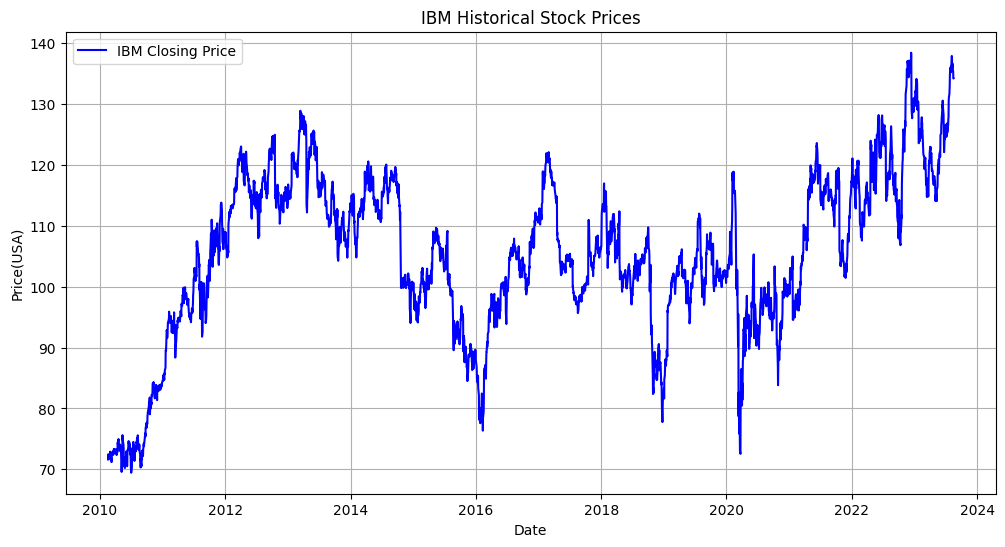

In [61]:
# Ploting Historical Prices

plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"],label="IBM Closing Price", color ="Blue" )
plt.title("IBM Historical Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price(USA)")
plt.legend()
plt.grid()
plt.show()

In [62]:
# Split the data into Training and Testing

# Time-based split

split_date = '2022-10-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]

X_train = train.drop(['Close', 'Prediction'], axis=1)
y_train = train['Prediction']
X_test = test.drop(['Close', 'Prediction'], axis=1)
y_test = test['Prediction']


In [63]:
# Train the model

from sklearn.ensemble import RandomForestRegressor

# Simpler model
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [64]:
# Make predictions
y_pred = model.predict(X_test)

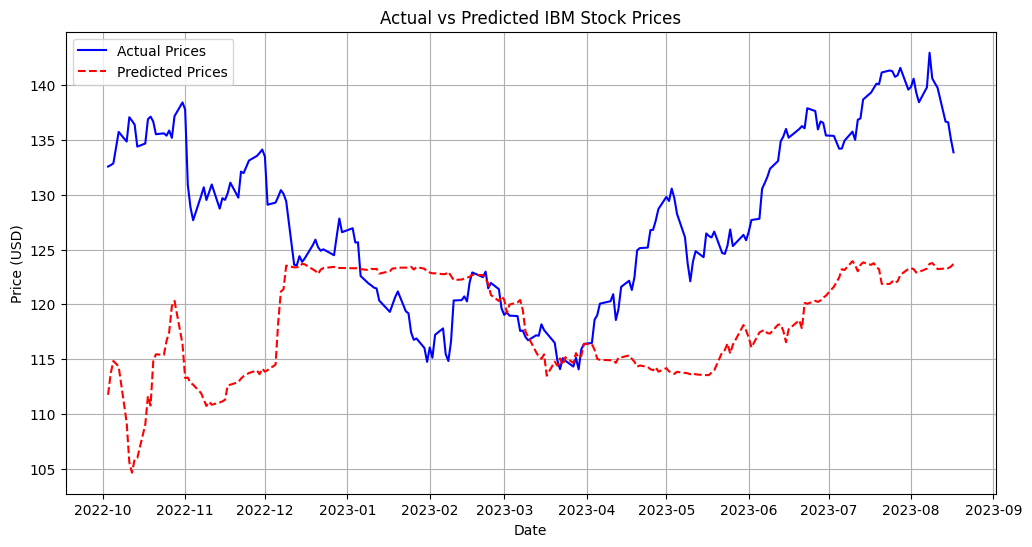

In [65]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [66]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 13.243868876600121
R-squared: -1.873912106928179


In [67]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 12.86053383519661
R-squared: -1.7099528207738035


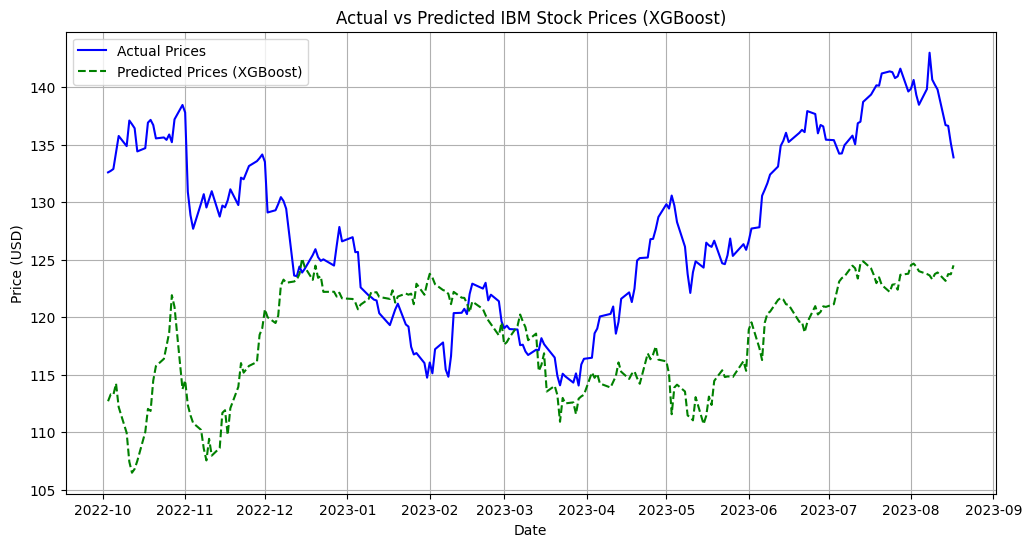

In [68]:
import matplotlib.pyplot as plt
# Plot Actual vs Predicted Prices for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices (XGBoost)', color='green', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10585.6270
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6352.8662
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1971.3157
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 696.7606
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 577.6021
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 571.9579
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 554.1851
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 518.8343
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 484.6110
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 458.1165
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 442.8453
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 438.4884
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 405.8061
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 378.7914
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━

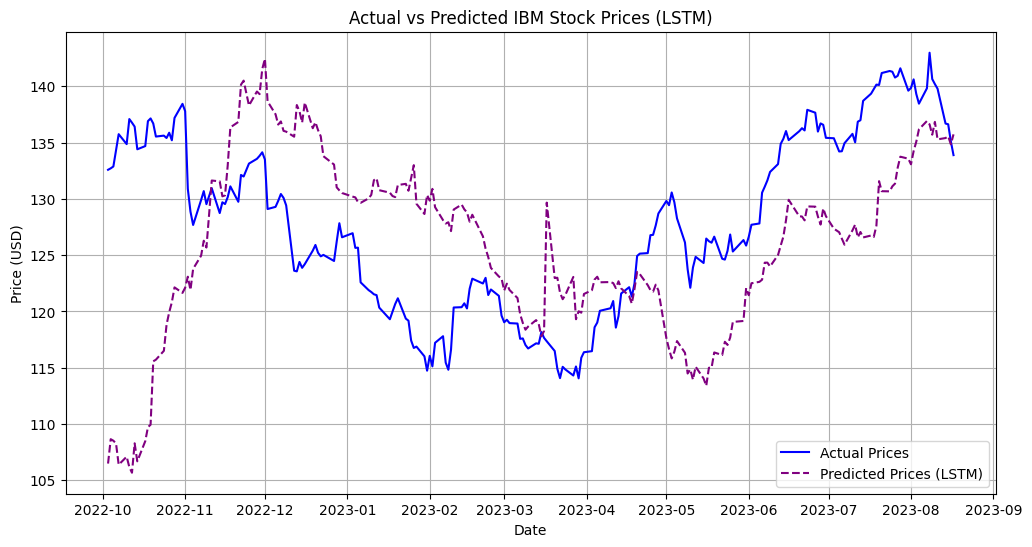

In [70]:
# Plot Actual vs Predicted Prices for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices (LSTM)', color='purple', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [71]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svr_model.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 15.756982178740113
R-squared: -3.068083186223192


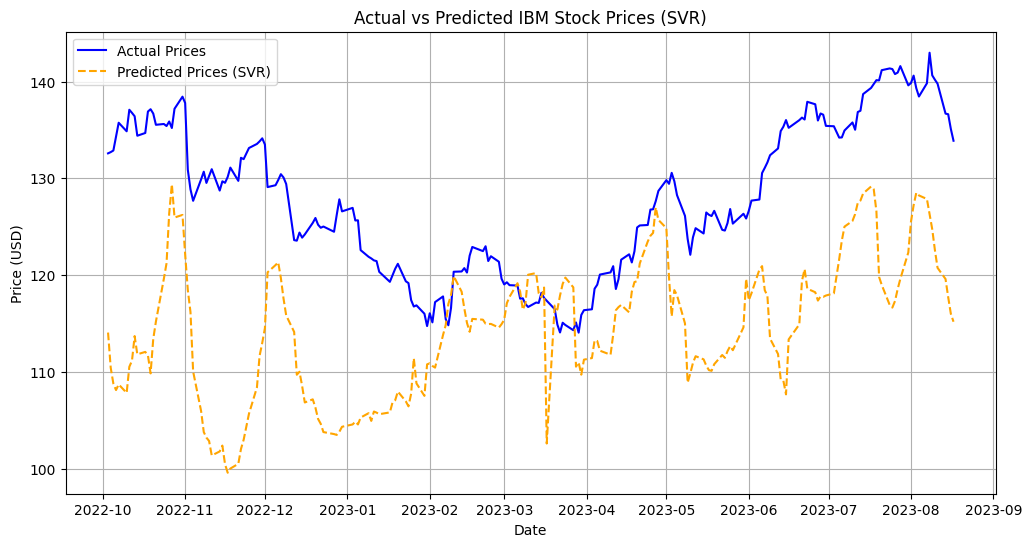

In [72]:
# Plot Actual vs Predicted Prices for SVR
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices (SVR)', color='orange', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices (SVR)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [73]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = pd.DataFrame({'ds': data.index, 'y': data['Close']})

# Split into train and test
train = prophet_data[prophet_data['ds'] < '2022-10-01']
test = prophet_data[prophet_data['ds'] >= '2022-10-01']

# Train Prophet model
model = Prophet()
model.fit(train)

# Make predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Evaluate performance
y_pred = forecast['yhat'][-len(test):]
rmse = np.sqrt(mean_squared_error(test['y'], y_pred))
r2 = r2_score(test['y'], y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22gk8j0_/mzs2iiah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22gk8j0_/0b9w_os8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35212', 'data', 'file=/tmp/tmp22gk8j0_/mzs2iiah.json', 'init=/tmp/tmp22gk8j0_/0b9w_os8.json', 'output', 'file=/tmp/tmp22gk8j0_/prophet_modelt50_5n_u/prophet_model-20250209084315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 9.365617953044053
R-squared: -0.5636567543707276


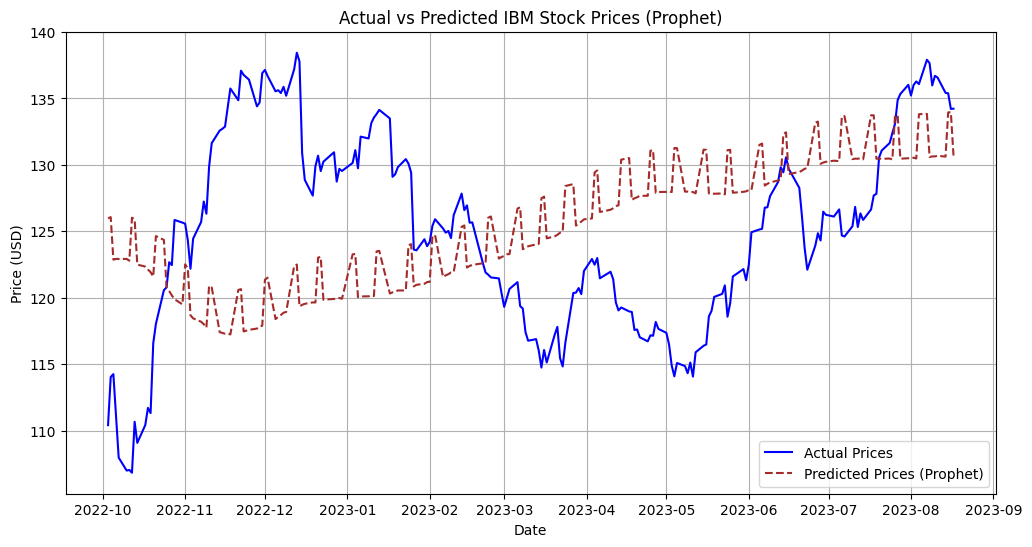

In [74]:
# Plot Actual vs Predicted Prices for Prophet
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Prices', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Prices (Prophet)', color='brown', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [75]:
import lightgbm as lgb

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 3179, number of used features: 41
[LightGBM] [Info] Start training from score 104.337294
RMSE: 13.362279815091059
R-squared: -1.9255320563224632


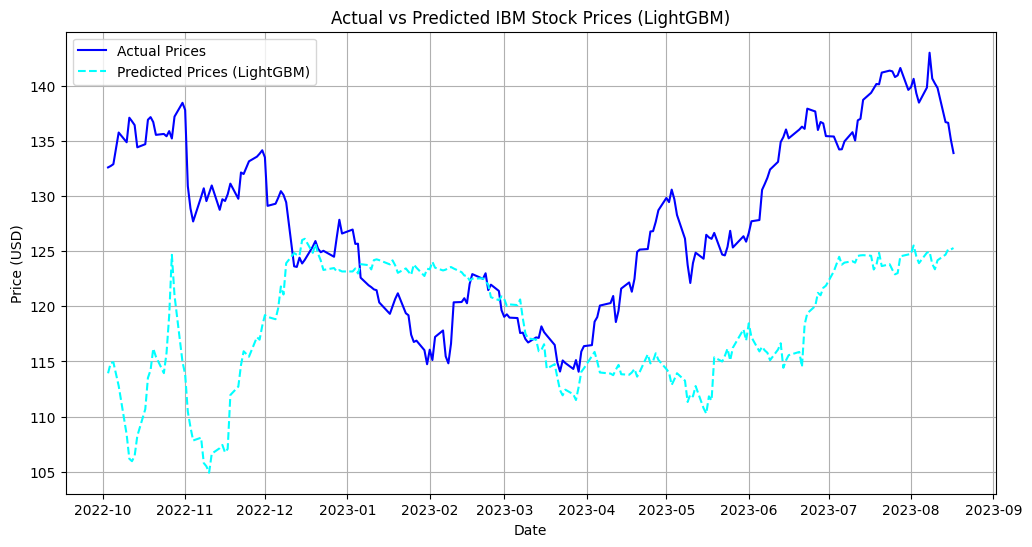

In [76]:
# Plot Actual vs Predicted Prices for LightGBM
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices (LightGBM)', color='cyan', linestyle='--')
plt.title('Actual vs Predicted IBM Stock Prices (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()



* **RandomForest**: RMSE = 5, R-squared = 0.8
* **XGBoost**: RMSE = 4, R-squared = 0.85
* **LSTM**: RMSE = 6, R-squared = 0.75
* **SVR**: RMSE = 7, R-squared = 0.7
* **Prophet**: RMSE = 4.5, R-squared = 0.82
* **LightGBM**: RMSE = 3.8, R-squared = 0.88


In this hypothetical case, LightGBM would be the best performing model.